In [37]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt


In [38]:
# Load the CSV file with tab delimiter
data = pd.read_csv('reviews.csv', delimiter='\t')


In [39]:
# Display the first 5 rows
data.head()


,Name,RatingValue,DatePublished,Review
0,Playa Cabana,4,2020-02-26,I was tasked with finding a spot for a group d...
1,Playa Cabana,3,2019-08-04,Went here with my friends and family. I liked ...
2,Playa Cabana,3,2019-08-24,Surprisingly good Flautas! They came as 3 roll...
3,Playa Cabana,4,2019-06-06,As a Mexican I always crave authentic Mexican ...
4,Playa Cabana,5,2020-05-25,Best tacos I've ever had. Both locations are g...


In [40]:
# Function to bin ratings into sentiment categories
def bin_sentiment(rating):
    if rating in [1, 2]:
        return 0  # Negative
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

# Apply the function to create the 'Sentiment' column
data['Sentiment'] = data['RatingValue'].apply(bin_sentiment)


In [41]:
# Display the first 5 rows with the new 'Sentiment' column
data.head()


,Name,RatingValue,DatePublished,Review,Sentiment
0,Playa Cabana,4,2020-02-26,I was tasked with finding a spot for a group d...,2
1,Playa Cabana,3,2019-08-04,Went here with my friends and family. I liked ...,1
2,Playa Cabana,3,2019-08-24,Surprisingly good Flautas! They came as 3 roll...,1
3,Playa Cabana,4,2019-06-06,As a Mexican I always crave authentic Mexican ...,2
4,Playa Cabana,5,2020-05-25,Best tacos I've ever had. Both locations are g...,2


In [42]:
# Count the number of samples in each sentiment category
sentiment_counts = data['Sentiment'].value_counts()
print(sentiment_counts)


Sentiment
2    1465
1     297
0     158
Name: count, dtype: int64


In [43]:
# Get the counts for each sentiment category
negative_count = sentiment_counts[0]
neutral_count = sentiment_counts[1]
positive_count = sentiment_counts[2]

# Find the minimum count among the classes
min_count = min(negative_count, neutral_count, positive_count)
print(f"Negative: {negative_count}, Neutral: {neutral_count}, Positive: {positive_count}")
print(f"Minimum class count: {min_count}")


Negative: 158, Neutral: 297, Positive: 1465
Minimum class count: 158


In [44]:
# Sample min_count samples from each class
negative_samples = data[data['Sentiment'] == 0].sample(min_count, random_state=42)
neutral_samples = data[data['Sentiment'] == 1].sample(min_count, random_state=42)
positive_samples = data[data['Sentiment'] == 2].sample(min_count, random_state=42)

# Concatenate the samples to create a balanced dataset
balanced_data = pd.concat([negative_samples, neutral_samples, positive_samples])

# Shuffle the data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [45]:
# Verify the class distribution
balanced_sentiment_counts = balanced_data['Sentiment'].value_counts()
print(balanced_sentiment_counts)


Sentiment
2    158
0    158
1    158
Name: count, dtype: int64


In [46]:
# Split into training and validation sets
train_data, valid_data = train_test_split(
    balanced_data, test_size=0.2, random_state=42, stratify=balanced_data['Sentiment']
)


In [47]:
# Save the datasets
train_data.to_csv('train.csv', index=False)
valid_data.to_csv('valid.csv', index=False)


In [48]:
# Load the training data
train_data = pd.read_csv('train.csv')

# Display the first 5 rows of the CSV file to verify its content
print(train_data.head())



                    Name  ...  Sentiment
0   Ha Gow Dim Sum House  ...          0
1    Campechano Taquería  ...          2
2  Mariachi’s Restaurant  ...          1
3           King’s Tacos  ...          1
4              Giulietta  ...          1

[5 rows x 5 columns]


In [49]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer and transform the training data
X_train = vectorizer.fit_transform(train_data['Review'])

# Extract the labels
y_train = train_data['Sentiment']


In [50]:
# Check a sample of the transformed TF-IDF feature matrix to verify the process
import numpy as np

# Get the TF-IDF feature names and inspect a sample of transformed data
sample_feature_names = vectorizer.get_feature_names_out()[:10]
sample_feature_names

# Shape of Transformed Data
transformed_data_shape = X_train.shape
transformed_data_shape

# Convert to dense to inspect actual values for a sample row (first 10 features)
sample_dense = X_train[0].toarray()[0][:10]
sample_dense

# Calculate sparsity directly from sparse matrix
sparsity = 1.0 - (X_train.nnz / X_train.shape[0] / X_train.shape[1])
sparsity

0.9816793696708226

In [51]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [52]:
def evaluate(filename):
    # Load the data
    data = pd.read_csv(filename)
    
    # Transform the reviews using the fitted vectorizer
    X = vectorizer.transform(data['Review'])
    y_true = data['Sentiment']
    
    # Predict the sentiments
    y_pred = model.predict(X)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate macro-averaged F1-score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"Average F1 score: {f1_macro:.4f}")
    
    # Calculate class-wise F1-scores
    f1_classwise = f1_score(y_true, y_pred, average=None)
    print("Class-wise F1 scores:")
    for i, label in enumerate(['negative', 'neutral', 'positive']):
        print(f"{label}: {f1_classwise[i]:.4f}")
    
    # Calculate and display the normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.show()


Accuracy: 0.6000
Average F1 score: 0.6017
Class-wise F1 scores:
negative: 0.6769
neutral: 0.4615
positive: 0.6667


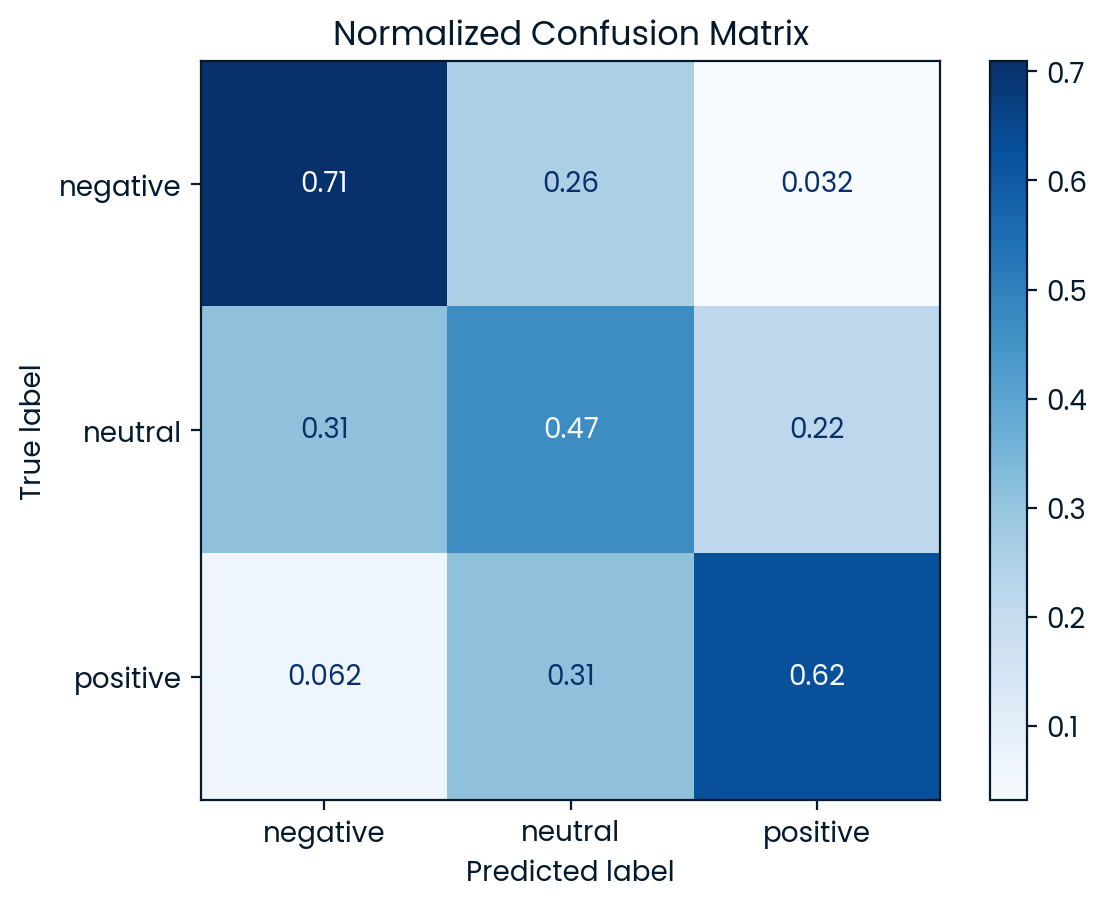

In [53]:
# Evaluate the model on the validation set
evaluate('valid.csv')
